## Project: Unsupervised Learning
----------------------------------------
-----------------------------------------

We will be using the Credit Card Customer Data for this project.

----------------------------
## Context: 
-----------------------------
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.


----------------------------
## Objective: 
-----------------------------

Identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

--------------------------
## About the data:
--------------------------
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

- Sl_no - Customer Serial Number
- Customer Key - Customer identification
- Avg_Credit_Limit	- Average credit limit (currency is not specified, you can make an assumption around this)
- Total_Credit_Cards	- Total number of credit cards 
- Total_visits_bank	- Total bank visits
- Total_visits_online -	 Total online visits
- Total_calls_made - Total calls made

## Importing libraries and overview of the dataset

In [40]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import shapiro

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


#if the below line of code gives an error, then uncomment the following code to install the sklearn_extra library
#!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [5]:
data = pd.read_excel('Credit Card Customer Data.xlsx')
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


#### Check the info of the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observations:**

- There are 660 observations and 7 columns in the dataset.
- All columns have 660 non-null values i.e. there are no missing values.
- All columns are of int64 data type.

**There are no missing values. Let us now figure out the uniques in each column.** 

In [7]:
data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

- Customer key, which is an identifier, has repeated values. We should treat the same accordingly before applying any algorithm.

## Data Preprocessing and Exploratory Data Analysis

In [14]:
# Identify the duplicated customer keys
duplicate_keys = data.duplicated(subset=['Customer Key'])

In [15]:
# Drop duplicated keys
data = data.drop_duplicates(subset=['Customer Key'])

We have done some basic checks. Now, let's drop the variables that are not required for our analysis.

In [16]:
data.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

Now that we have dropped unnecessary column. We can again check for duplicates. Duplicates would mean customers with identical features.

In [17]:
data[data.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


We can drop these duplicated rows from the data

In [18]:
data=data[~data.duplicated()]

In [19]:
data.shape

(644, 5)

- After removing duplicated keys and rows and unnecessary columns, there are 644 unique observations and 5 columns in our data.

#### Summary Statistics

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,644.0,34543.478261,37428.704286,3000.0,11000.0,18000.0,48000.00,200000.0
Total_Credit_Cards,644.0,4.694099,2.175338,1.0,3.0,5.0,6.00,10.0
Total_visits_bank,644.0,2.395963,1.626964,0.0,1.0,2.0,4.00,5.0
Total_visits_online,644.0,2.624224,2.957728,0.0,1.0,2.0,4.00,15.0
Total_calls_made,644.0,3.608696,2.880025,0.0,1.0,3.0,5.25,10.0


**Observations:___________**

- All features have 644 values - which is good because we don't have to worry about i mputing missing values
- Avg_Credit_limit has a large mean (34K) and a very large standard deviation (37K)
- Total Credit Card average is 4.69 with a std deviation of 2.17 - the most typical credit card count (50% percentile) is 5
- Total Bank Visits has a mean of 2.39 and std dev 1.62 - which means that some people never visit the bank (min of 0)
- Total Visits Online has a mean of 2.6 and std dev of 2.9 - which means that some people never visit the website (min of 0)
- Lasttly, total calls has a mean of 3.6 and std dev of 2.9 - with 50% showing = 3, calls are fairly prevalant

#### Now let's go ahead with the exploring each variable at hand. We will check the distribution and outliers for each variable in the data.

Avg_Credit_Limit
Skew : 2.19
Mean: 34543.48 | Median: 18000.0 | 2nd Qrt: 11000.0 | 3rd Qrt: 48000.0
p-value: 0.0, stat: 0.725 and probably NOT Gaussian 


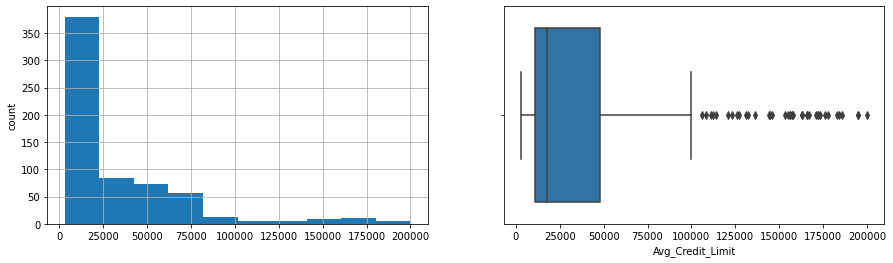

Total_Credit_Cards
Skew : 0.17
Mean: 4.69 | Median: 5.0 | 2nd Qrt: 3.0 | 3rd Qrt: 6.0
p-value: 0.0, stat: 0.956 and probably NOT Gaussian 


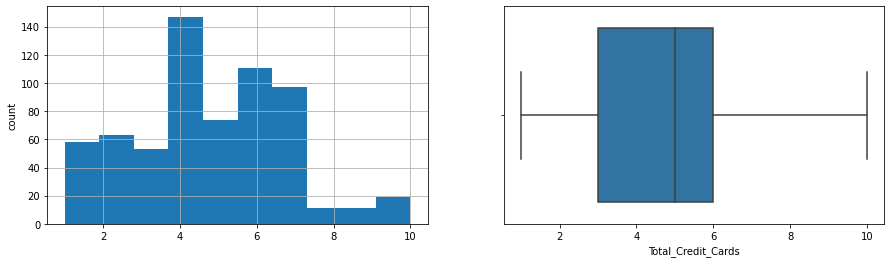

Total_visits_bank
Skew : 0.15
Mean: 2.4 | Median: 2.0 | 2nd Qrt: 1.0 | 3rd Qrt: 4.0
p-value: 0.0, stat: 0.916 and probably NOT Gaussian 


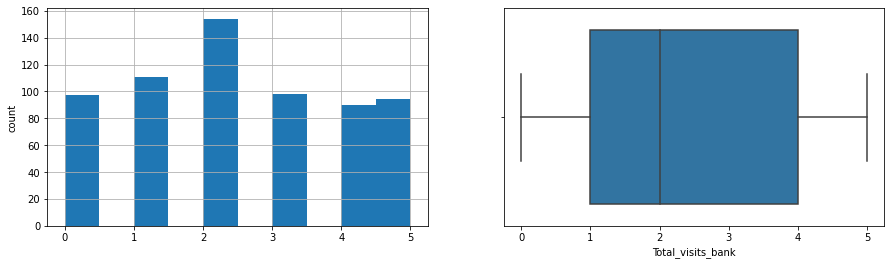

Total_visits_online
Skew : 2.21
Mean: 2.62 | Median: 2.0 | 2nd Qrt: 1.0 | 3rd Qrt: 4.0
p-value: 0.0, stat: 0.748 and probably NOT Gaussian 


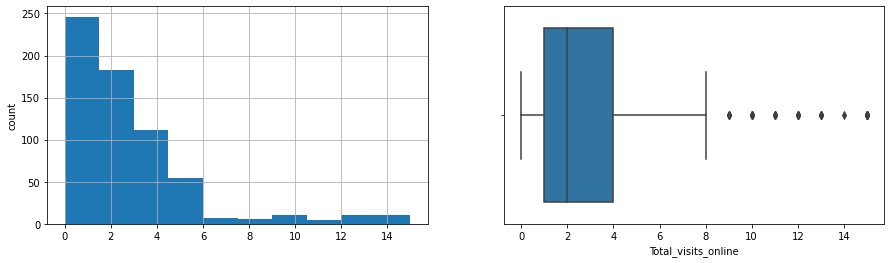

Total_calls_made
Skew : 0.65
Mean: 3.61 | Median: 3.0 | 2nd Qrt: 1.0 | 3rd Qrt: 5.25
p-value: 0.0, stat: 0.916 and probably NOT Gaussian 


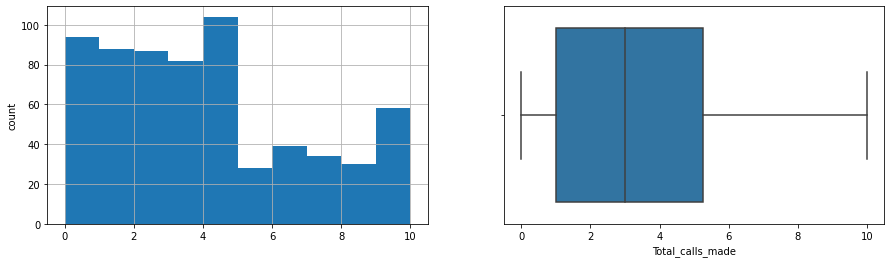

In [48]:
# Uncomment and complete the code by filling the blanks 

def fn_guassian(dataIN):
    
    stat, p = shapiro(dataIN)
    stat = round(stat,3)
    p = round(p,3)
    normtxt = 'probably NOT Gaussian'
    if p > .05:
        normtxt = 'probably Gaussian'
    print(f'p-value: {p}, stat: {stat} and {normtxt} ')


for col in data.columns:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist()
    print(f'Mean: {round(data[col].mean(),2)} | Median: {data[col].median()} | 2nd Qrt: {data[col].quantile(0.25)} | 3rd Qrt: {data[col].quantile(0.75)}')
    fn_guassian(data[col])
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()

**Observation:______________**

- none of the distributions appear to be gaussian (confirmed by shapiro testing)
- Avg credit limit and Total visits online are the only data points with outliers - we'll have to be careful on how we treat these variables in our analysis so as not to skew our results unintentionally
- Avg credit limit skewed left - with a mean of 35K and median of 18K. The IQR is 11K to 48K
- Total credit cards has a mean of 4.6 and median of 5 - with an IQR of 3 to 6
- Total visits to bank has a mean of 2.4 and median of 2 - with an IQR of 1 to 4. 
- Total Calls Made is skewed slightly left - with a mean of 3.6 and median of 3 - with an IQR of 1 to 5.25. There's quite a bit of spread in this data.



**Now, let's check the correlation among different variables.**

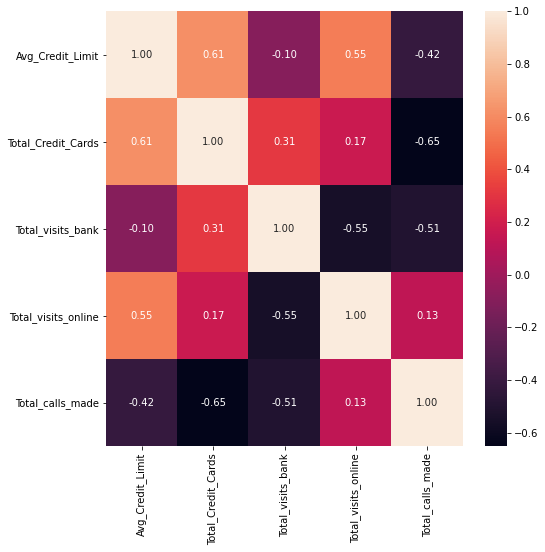

In [49]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(), annot=True, fmt='0.2f')
plt.show()

**Observation:**

- Avg_Credit_Limit is positively correlated with Total_Credit_Cards Total_visits_online which can makes sense.
- Avg_Credit_Limit is negatively correlated with Total_calls_made and Total_visits_bank.
- Total_visits_bank, Total_visits_online, Total_calls_made are negatively correlated which implies that majority of customers use only one of these channels to contact the bank.

#### Scaling the data

In [50]:
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [51]:
data_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.750192,-1.239437,-0.858684,-0.549573,-1.253982
1,0.413280,-0.779381,-1.473803,2.495669,1.873420
2,0.413280,1.060843,-0.858684,0.127148,0.135974
3,-0.121485,0.140731,-0.858684,-0.549573,0.135974
4,1.750192,0.600787,-1.473803,3.172390,-0.211515


In [52]:
#Creating copy of the data to store labels from each algorithm
data_scaled_copy = data_scaled.copy(deep=True)

## K-Means

Let us now fit k-means algorithm on our scaled data and find out the optimum number of clusters to use.

We will do this in 3 steps:
1. Initialize a dictionary to store the SSE for each k
2. Run for a range of Ks and store SSE for each run
3. Plot the SSE vs K and find the elbow

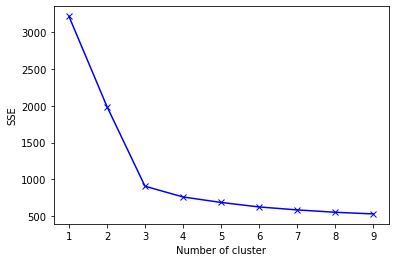

In [53]:
# step 1
sse = {} 

# step 2 - iterate for a range of Ks and fit the scaled data to the algorithm. Use inertia attribute from the clustering object and 
# store the inertia value for that k 
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=1).fit(data_scaled)
    sse[k] = kmeans.inertia_

# step 3
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

- Looking at the plot, we can say that elbow point is achieved for k=3.
- We will fit the k-means again with k=3 to get the labels.

In [54]:
kmeans = KMeans(n_clusters=3, random_state=1) #Apply the K-Means algorithm
kmeans.fit(data_scaled) #Fit the kmeans function on the scaled data

#Adding predicted labels to the original data and scaled data 
data_scaled_copy['Labels'] = kmeans.predict(data_scaled) #Save the predictions on the scaled data from K-Means
data['Labels'] = kmeans.predict(data_scaled) #Save the predictions on the scaled data from K-Means

**Observations for Question 4 ______________**

> ### Reason for selecting k=3 - Jose Medina answer:
> - According to the plot, after K=3, the Within-Cluster-Sum of Squared Errors starts to diminish

--------


We have generated the labels with k-means. Let us look at the various features based on the labels.

In [58]:
#Number of observations in each cluster
data.Labels.value_counts()

1    374
0    221
2     49
Name: Labels, dtype: int64

In [59]:
#Calculating summary statistics of the original data for each label
mean = data.groupby('Labels').mean()
median = data.groupby('Labels').median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


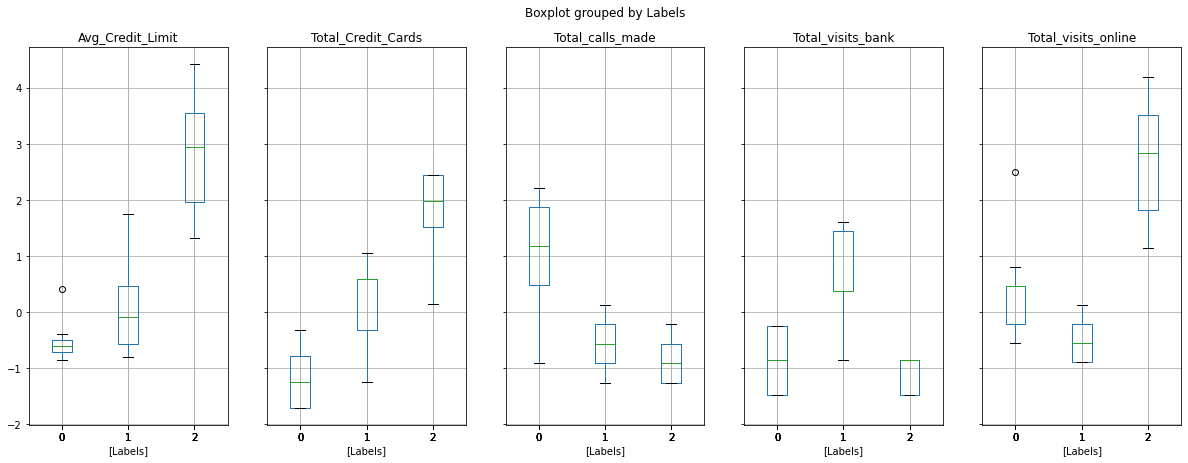

In [60]:
#Visualizing different features w.r.t K-means labels
data_scaled_copy.boxplot(by = 'Labels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:_______________**

> First, it should be noted that because underlying data is non-normal (as shown earlier), using k-means is probably not the best approach as distributions are skewed and means are not representative of underlying distributions. Using medians would be better because it ensures we're not biasing conclusions with the outliers present in a few features. 

> Cluster 2 has only 49 observations, which makes sense in a way because they have the highest median Avg_Credit_Limit (probably wealthier). These higher Avg_Credit_Limit individuals visits online far more frequently (highest Total_visits_online median) than other clusters, and also have higher median Total_Credit_Cards than other clusters.

> The other two clusters are a bit more mixed
  > - Cluster 0, has the largest count of observations (374), and has the lowest median Avg_Credit_Limit, lowest median Total_Credit_Cards count, and tend to place more Total_Calls_made (higher median calls) than other clusters (perhaps because of more strained financial circumstances)
  
  > - Lastly, Cluster 1, has a total count of observations of 221 - they have the highest IQR of Total_Visits_bank and lowest Total_visits_online. But otherwise, are middle of the road between cluster 0 and 2 in terms of Avg_Credit_Limit, Total_Credit_Cards, Total_Calls_made

## Gaussian Mixture

Let's create clusters using Gaussian Mixture Models

In [65]:
gmm = GaussianMixture(n_components = 3,random_state = 1) #Apply the Gaussian Mixture algorithm
gmm.fit(data_scaled) #Fit the gmm function on the scaled data

data_scaled_copy['GmmLabels'] = gmm.predict(data_scaled)
data['GmmLabels'] = gmm.predict(data_scaled)

In [66]:
#Number of observations in each cluster
data.GmmLabels.value_counts()

1    374
0    221
2     49
Name: GmmLabels, dtype: int64

In [67]:
#Calculating summary statistics of the original data for each label
original_features = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

mean = data.groupby('GmmLabels').mean()
median = data.groupby('GmmLabels').median()
df_gmm = pd.concat([mean, median], axis=0)
df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_gmm[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


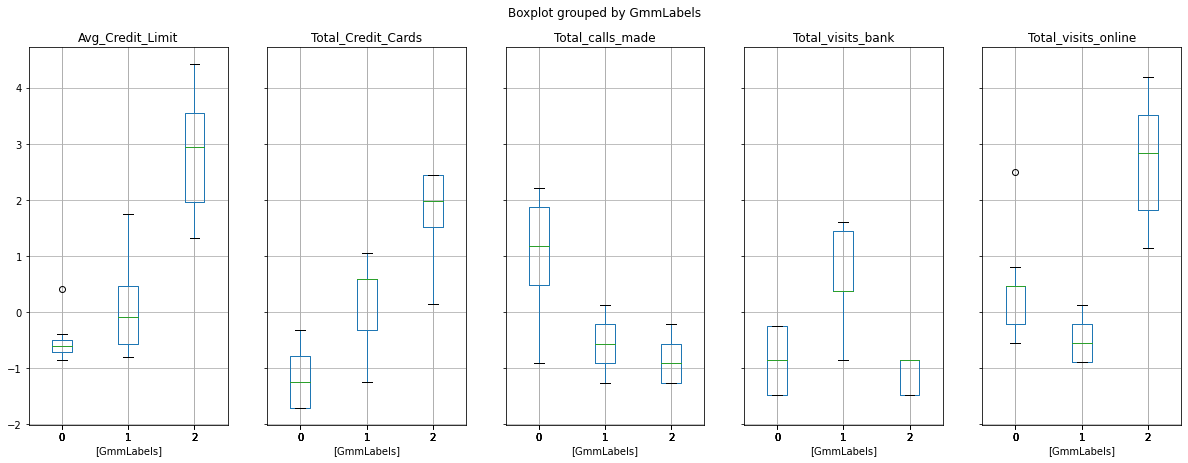

In [68]:
# plotting boxplots with the new GMM based labels

features_with_lables = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","GmmLabels"]

data_scaled_copy[features_with_lables].boxplot(by = 'GmmLabels', layout = (1,5),figsize=(20,7))
plt.show()

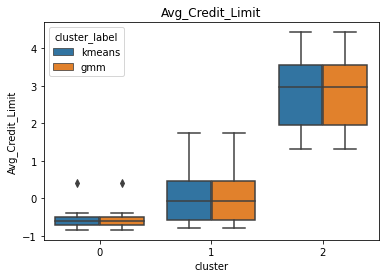

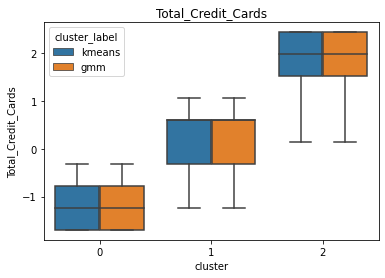

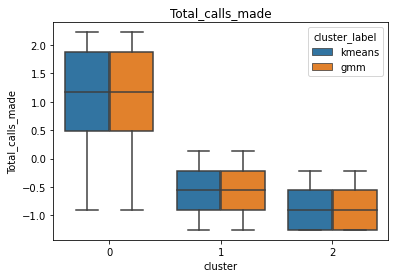

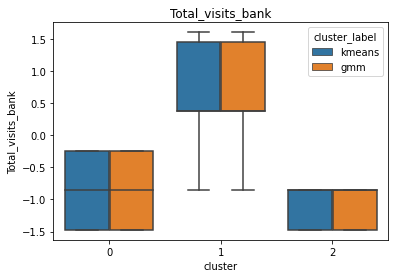

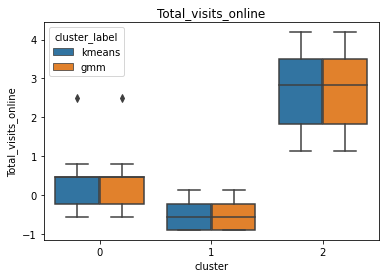

In [103]:
# Jose Medina - custom analysis shows both plot side by side

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","GmmLabels"]
df_gmm = data_scaled_copy[features_with_lables]
df_gmm['cluster'] = df_gmm['GmmLabels']
df_gmm['cluster_label'] = 'gmm'

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","Labels"]
df_kmeans = data_scaled_copy[features_with_lables]
df_kmeans['cluster'] = df_kmeans['Labels']
df_kmeans['cluster_label'] = 'kmeans'

df_compare = pd.concat([ df_kmeans, df_gmm], axis=0)

value_cols = ["Avg_Credit_Limit","Total_Credit_Cards","Total_calls_made", "Total_visits_bank","Total_visits_online"]

for col in value_cols:
    
    sns.boxplot(data=df_compare, x='cluster', y=col, hue='cluster_label').set_title(col)
    plt.show()


**Cluster Profiles:____________**

> Cluster 2 has 49 observations, the highest median Avg_Credit_Limit (probably wealthier). These higher Avg_Credit_Limit individuals visits online far more frequently (highest Total_visits_online median) than other clusters, and also have higher median Total_Credit_Cards than other clusters.

> The other two clusters are a bit more mixed
  > - Cluster 0, has the largest count of observations (374), and has the lowest median Avg_Credit_Limit, lowest median Total_Credit_Cards count, and tend to place more Total_Calls_made (higher median calls) than other clusters (perhaps because of more strained financial circumstances)
  
  > - Lastly, Cluster 1, has a total count of observations of 221 - they have the highest IQR of Total_Visits_bank and lowest Total_visits_online. But otherwise, are middle of the road between cluster 0 and 2 in terms of Avg_Credit_Limit, Total_Credit_Cards, Total_Calls_made

**Comparing Clusters:____________**

> A side by side comparison between GMM and K-Means boxplots/clusters appears largely identical - therefore conclusions/profiles amongst two methods are the same. Also can be observed by visually comparing the custom boxplots above.

## K-Medoids

In [80]:
kmedo = KMedoids(n_clusters = 3, random_state=1) #Apply the K-Medoids algorithm
kmedo.fit(data_scaled) #Fit the kmedo function on the scaled data

data_scaled_copy['kmedoLabels'] = kmedo.predict(data_scaled)
data['kmedoLabels'] = kmedo.predict(data_scaled)

In [81]:
#Number of observations in each cluster
data.kmedoLabels.value_counts()

2    289
0    222
1    133
Name: kmedoLabels, dtype: int64

In [82]:
#Calculating summary statistics of the original data for each label
mean = data.groupby('kmedoLabels').mean()
median = data.groupby('kmedoLabels').median()
df_kmedoids = pd.concat([mean, median], axis=0)
df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmedoids[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12216.216216,85052.631579,28449.826990,12000.0,68000.0,20000.0
Total_Credit_Cards,2.423423,7.030075,5.363322,2.0,7.0,5.0
Total_visits_bank,0.950450,1.691729,3.830450,1.0,2.0,4.0
Total_visits_online,3.554054,4.639098,0.982699,4.0,2.0,1.0
Total_calls_made,6.878378,1.969925,1.851211,7.0,2.0,2.0


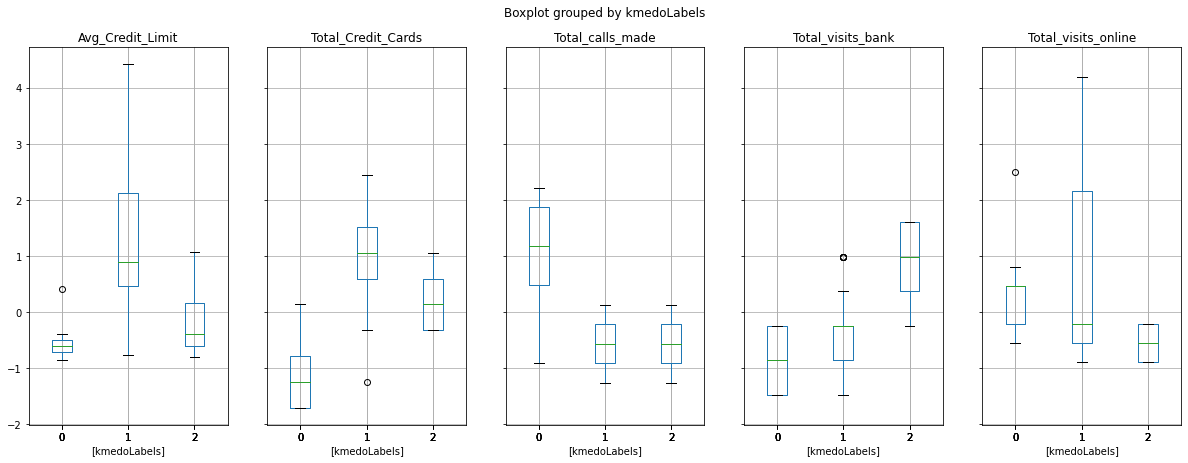

In [83]:
#plotting boxplots with the new K-Medoids based labels

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","kmedoLabels"]

data_scaled_copy[features_with_lables].boxplot(by = 'kmedoLabels', layout = (1,5),figsize=(20,7))
plt.show()

Let's compare the clusters from K-Means and K-Medoids 

In [88]:
comparison = pd.concat([df_kmedoids, df_kmeans], axis=1)[original_features]
comparison

,Avg_Credit_Limit,Avg_Credit_Limit,Total_Credit_Cards,Total_Credit_Cards,Total_visits_bank,Total_visits_bank,Total_visits_online,Total_visits_online,Total_calls_made,Total_calls_made
group_0 Mean,12216.216216,12239.819005,2.423423,2.411765,0.950450,0.945701,3.554054,3.561086,6.878378,6.891403
group_1 Mean,85052.631579,33893.048128,7.030075,5.508021,1.691729,3.489305,4.639098,0.975936,1.969925,1.997326
group_2 Mean,28449.826990,140102.040816,5.363322,8.775510,3.830450,0.591837,0.982699,10.979592,1.851211,1.102041
group_0 Median,12000.000000,12000.000000,2.000000,2.000000,1.000000,1.000000,4.000000,4.000000,7.000000,7.000000
group_1 Median,68000.000000,31500.000000,7.000000,6.000000,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000
group_2 Median,20000.000000,145000.000000,5.000000,9.000000,4.000000,1.000000,1.000000,11.000000,2.000000,1.000000


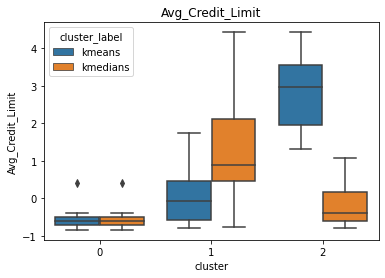

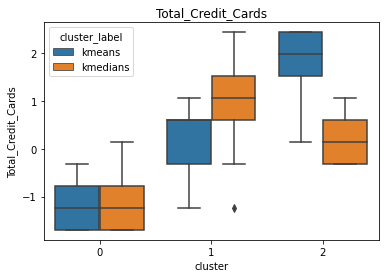

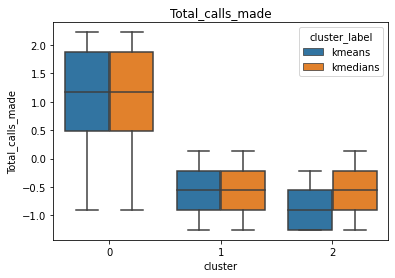

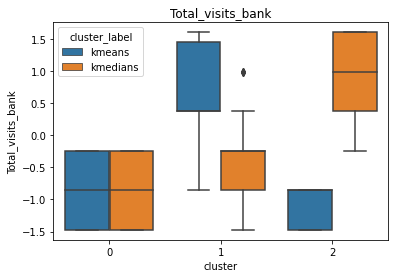

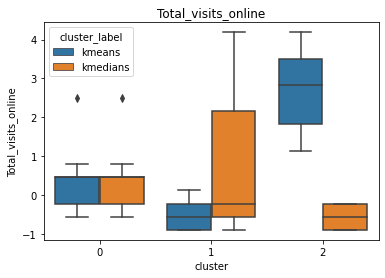

In [99]:
# Jose Medina - custom analysis shows both plot side by side

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","kmedoLabels"]
df_kmedo = data_scaled_copy[features_with_lables]
df_kmedo['cluster'] = df_kmedo['kmedoLabels']
df_kmedo['cluster_label'] = 'kmedians'

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","Labels"]
df_kmeans = data_scaled_copy[features_with_lables]
df_kmeans['cluster'] = df_kmeans['Labels']
df_kmeans['cluster_label'] = 'kmeans'

df_compare = pd.concat([ df_kmeans, df_kmedo], axis=0)

value_cols = ["Avg_Credit_Limit","Total_Credit_Cards","Total_calls_made", "Total_visits_bank","Total_visits_online"]

for col in value_cols:
    
    sns.boxplot(data=df_compare, x='cluster', y=col, hue='cluster_label').set_title(col)
    plt.show()


**Cluster Profiles:____________**

> Clusters 0, 1, and 2 are much more evenly distributed with K-Medoids 
> - Cluster 2:    289,
> - Cluster 0:    222 
> - Cluster 1:    133

> Cluster 2 has 289 observations, the highest Total_visits_bank, and lowest Total_visits_online (the opposite conclusion from K-means!). Their Avg_Credit_Limit and Total_Credit_Cards sits between Cluster 0 and 1 (middle of the road) and they place relatively few calls (as low as cluster 1). With K-Means, Cluster 2 had the highest Avg_Credit_Limit, but with K-Medoids, it is now the second highest.

> Cluster 0, still has the lowest Avg_Credit_Limit (consistent with K-Means conclusion), and Lowest_Total_Credit_Cards, and amongst the lowest Total_Visits_bank. They have the highest Total_Calls_Made (consistent between K-means and K-medoids). In general - Cluster 0 positions on Boxplot did NOT change materially with respect to itself, but other clusters did change.

> Cluster 1 experienced a big change in terms of Avg_Credit_Limit - with K-Medoids, Cluster 1 now has the highest Avg_Credit_Limit of all clusters. Cluster 1 now also has the highest Total_Credit_Cards, and biggest IQR for Total_visits_online

**Comparing Clusters:____________**

> A side by side comparison reveals the following changes (consistent with my prior observation that non-normal distributions would largely skew the results of K-Means)
> - Cluster 2 - Total_visits_bank, and lowest Total_visits_online (the opposite conclusion from K-means!), With K-Means, Cluster 2 had the highest Avg_Credit_Limit, but with K-Medoids, it is now only the second highest.
> - Cluster 0 positions on Boxplot did NOT change materially with respect to itself between K-Means and K-Medoids. This suggests that cluster 0, as a subset, may have a distribution that approximates gaussian or at least has proximate distributions, median, and means describing their distribution.
> - Cluster 1 experiences large changes between methodologies - with K-Medoids, Cluster 1 now has the highest Avg_Credit_Limit of all clusters. Cluster 1 now also has the highest Total_Credit_Cards, and biggest IQR for Total_visits_onlin